In [25]:
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from astropy.io import fits
from POSEIDON.constants import R_Sun, R_J, M_J
import numpy as np
from spectres import spectres
from datetime import datetime
from matplotlib.pyplot import *
import time
import pickle
from matplotlib.pyplot import cm
from array import *
from astropy.io import fits
import glob
from matplotlib import rcParams
import colormaps as cmaps

rcParams["font.family"] = "sans-serif"
import matplotlib.pyplot as plt

# TODO:
### 1. Migrate plotting function into high res
### 2. Make tutorials

In [26]:
def get_coordinate_list(x_values, y_values):
    x, y = np.meshgrid(x_values, y_values)
    coordinates = np.dstack([x, y]).reshape(-1, 2)
    return [tuple(coord) for coord in coordinates]

6.497098567965876


/tmp/ipykernel_796242/3072253595.py:60: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_logL_SNR" + str(date_time) + ".pdf", fmt="pdf")


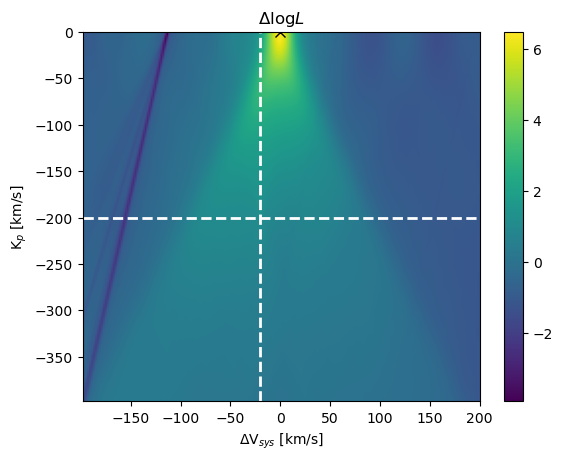

12.251732302727834


/tmp/ipykernel_796242/3072253595.py:88: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_CCF_SNR" + str(date_time) + ".pdf", fmt="pdf")


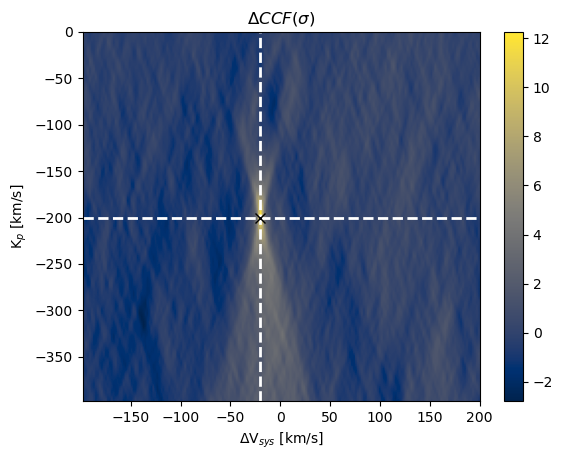

/tmp/ipykernel_796242/3072253595.py:102: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fmt" which is no longer supported as of 3.3 and will become an error two minor releases later
  savefig(output_path + name + "_CCF_slice.pdf", fmt="pdf")


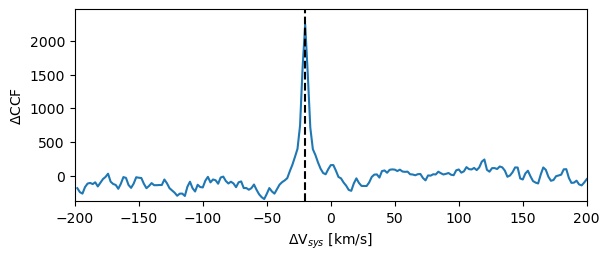

In [29]:
loglikelihoods = []
CCFs = []
CCF_per_phases = []
for n in range(1, 2):
    data_path = "./data/WASP-121b-injection-a10/"
    output_path = "./CC_output/WASP-121b/"
    output_path = "./CC_output/WASP-121b-injection-a10/"
    # output_path = f"./CC_output/WASP-76b-MAROON/night_{n}/"
    # output_path = f"./CC_output/WASP-76b/"
    name = "WASP-121b"
    # name = f"WASP-76b-MAROON-{n}"
    # name = f"WASP-76b"

    K_p_arr, V_sys_arr, RV_range, loglikelihood, CCF, CCF_per_phase = pickle.load(
        open(output_path + "Fe_cross_correlation_results.pic", "rb")
    )
    loglikelihoods.append(loglikelihood)
    CCFs.append(CCF)
    CCF_per_phases.append(CCF_per_phase)

loglikelihood = np.sum(loglikelihoods, axis=0)
CCF = np.sum(CCFs, axis=0)
CCF_per_phase = np.sum(CCF_per_phases, axis=0)

K_p = -200
V_sys = -20  # True value

stdev_range_x = np.where((K_p_arr < K_p - 15) | (K_p_arr > K_p + 15))[0]
stdev_range_y = np.where((V_sys_arr < V_sys - 15) | (V_sys_arr > V_sys + 15))[0]
stdev_range = get_coordinate_list(stdev_range_x, stdev_range_y)

loglikelihood = loglikelihood - np.mean(loglikelihood)
stdev = np.std(loglikelihood[stdev_range])
maxx = (loglikelihood / stdev).max()
print(maxx)
loc = np.where(loglikelihood / stdev == maxx)


fig, ax = subplots()
cax = ax.imshow(
    loglikelihood / stdev,
    extent=[V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()],
    aspect="auto",
    # interpolation="bilinear",
    origin="lower",
)

cbar = colorbar(cax)
axvline(x=V_sys, color="white", ls="--", lw=2)
axhline(y=K_p, color="white", ls="--", lw=2)
plot(V_sys_arr[loc[1]], K_p_arr[loc[0]], "xk", ms=7)
axis([V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("K$_{p}$ [km/s]")
title("$\Delta $log$L$")

now = datetime.now()  # current date and time
date_time = now.strftime("%m_%d_%H_%M")

savefig(output_path + name + "_logL_SNR" + str(date_time) + ".pdf", fmt="pdf")
show()
close()

# CCF
CCF = CCF - np.mean(CCF)
stdev = np.std(CCF[stdev_range])
maxx = (CCF / stdev).max()
print(maxx)
loc = np.where(CCF / stdev == maxx)
fig, ax = subplots()
cax = ax.imshow(
    CCF / stdev,
    extent=[V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()],
    aspect="auto",
    # interpolation="bilinear",
    # cmap="cividis",
    cmap=cmaps.cividis,
    origin="lower",
)
cbar = colorbar(cax)
axvline(x=V_sys, color="white", ls="--", lw=2)
axhline(y=K_p, color="white", ls="--", lw=2)
plot(V_sys_arr[loc[1]], K_p_arr[loc[0]], "xk", ms=7)
axis([V_sys_arr.min(), V_sys_arr.max(), K_p_arr.min(), K_p_arr.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("K$_{p}$ [km/s]")
title("$\Delta CCF (\sigma)$")
savefig(output_path + name + "_CCF_SNR" + str(date_time) + ".pdf", fmt="pdf")
show()
close()


# slice at Kp
index = np.argmin(np.abs(K_p_arr - K_p_arr[loc[0]]))
slicee = CCF[index]
plot(V_sys_arr, slicee)
axis([-200, 200, 1.1 * slicee.min(), 1.1 * slicee.max()])
xlabel("$\Delta$V$_{sys}$ [km/s]")
ylabel("$\Delta$CCF")
axvline(x=V_sys, ls="--", color="black")
subplots_adjust(left=0.1, right=0.9, top=0.7, bottom=0.3)
savefig(output_path + name + "_CCF_slice.pdf", fmt="pdf")
show()
close()

In [34]:
# CCF_per_phase
from POSEIDON.utility import read_high_res_data

phi = read_high_res_data(data_path)["phi"]
RV_min = min(
    [
        np.min(K_p_arr * np.sin(2 * np.pi * phi[i])) + np.min(V_sys_arr)
        for i in range(len(phi))
    ]
)
RV_max = max(
    [
        np.max(K_p_arr * np.sin(2 * np.pi * phi[i])) + np.max(V_sys_arr)
        for i in range(len(phi))
    ]
)

RV_range = np.arange(RV_min, RV_max + 1)

6.195658795288508


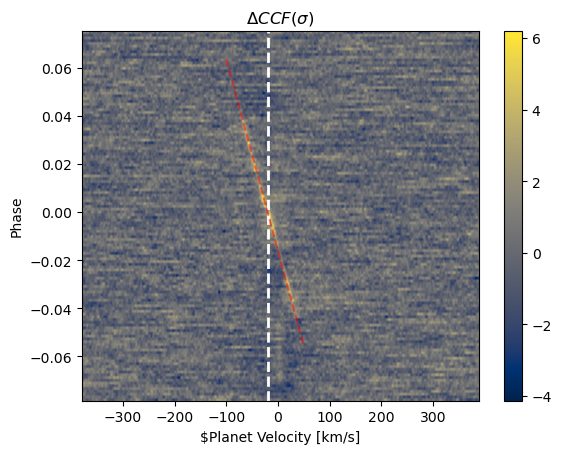

In [51]:
for i in range(len(CCF_per_phase)):
    CCF_per_phase[i] = CCF_per_phase[i] - np.mean(CCF_per_phase[i])
    stdev = np.std(CCF_per_phase[i])
    CCF_per_phase[i] = CCF_per_phase[i] / stdev
maxx = (CCF_per_phase).max()
print(maxx)
loc = np.where(CCF_per_phase / stdev == maxx)
fig, ax = subplots()
cax = ax.imshow(
    CCF_per_phase,
    extent=[RV_range.min(), RV_range.max(), phi.min(), phi.max()],
    aspect="auto",
    # interpolation="bilinear",
    # cmap="cividis",
    cmap=cmaps.cividis,
    origin="lower",
)


cbar = colorbar(cax)
axvline(x=V_sys, color="white", ls="--", lw=2)
axvline(y=0, color="white", ls="--", lw=2)
plt.plot(
    np.arange(-100, 50),
    (np.arange(-100, 50) + 20) / (-200) / (2 * np.pi),
    "--",
    color="red",
    alpha=0.5,
)
# plot(V_sys_arr[loc[1]], phi[loc[0]], "xk", ms=7)
# axis([V_sys_arr.min(), V_sys_arr.max(), phi.min(), phi.max()])
xlabel("Planet Velocity [km/s]")
ylabel("Phase")
title("$\Delta CCF (\sigma)$")
show()
close()

In [31]:
np.sum(CCF_per_phase[95], axis=0)

1.7053025658242404e-12

In [32]:
a = np.zeros((10, 10))
b = np.arange(10)

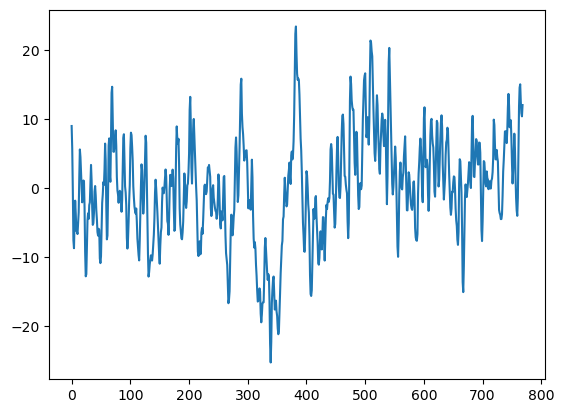

In [33]:
plt.plot(np.sum(CCF_per_phase, axis=0))

In [17]:
np.sum(CCFs, axis=0).shape

(200, 200)